In [220]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt

np.random.seed(42)
ROOT_PATH = os.path.normpath(os.path.join(os.getcwd(), os.pardir))
ROOT_PATH

'/home/franco/github/StatMatMethodsAI'

In [221]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    data = pd.read_csv("/content/drive/MyDrive/data.csv")
except:
    data = pd.read_csv(os.path.join(ROOT_PATH, "data", "data.csv"))
# Load the data

print("Shape of data {}".format(data.shape))

Shape of data (42000, 785)


In [222]:
def data_splits(X, Y, N_train):
    N = X.shape[1]

    # getting an array with indeces from 0 to N-1
    indeces = np.arange(N)
    # shuffling randomly
    np.random.shuffle(indeces)

    # get the first N_train for the train split (but now they are random)
    train_idx = indeces[:N_train]
    # the rest are for test split
    test_idx = indeces[N_train:]

    # slice the original datasets with an index array
    X_train = X[:, train_idx]  
    Y_train = Y[train_idx]
    
    X_test = X[:, test_idx]
    Y_test = Y[test_idx]

    # put in tuples the two splits
    return (X_train, Y_train), (X_test, Y_test)


def get_data_from_index(X, Y, indexes):
    
    # start from empty lists for both samples and labels
    final_X = []
    final_Y = []

    # for each chosen label
    for k in indexes:
        # find which samples have label=k
        idxs_k = (Y == k)
        # slice the samples and append them to a list
        final_X.append( X[:, idxs_k] )
        # same thing to the labels
        final_Y.append( Y[idxs_k] )

    # concatenate together all the previous iterations
    X = np.concatenate(final_X, axis=1)
    Y = np.concatenate(final_Y)

    # return the new dataset and labels
    return X, Y

In [247]:
def get_data_given_indeces_and_split(data, indeces, N_train):
    data_copied = np.array(data)
    X = data_copied[:, 1:]
    X = X.T
    Y = data_copied[:, 0]

    d, N = X.shape
    X_hat = np.concatenate((np.ones((1,N)), X), axis=0) #for logistic

    X_hat, Y = get_data_from_index(X_hat, Y, indeces)
    _, N = X_hat.shape

    if N_train > 0.90*N:
        print("N_train too big, was brouoght to 0.90*N")
        N_train = round(0.90*N)

    (X_train, Y_train), (X_test, Y_test) = data_splits(X_hat, Y, N_train) #X_hat for logistic
    
    Y_train = np.array(list(map(lambda x: 0 if x==indeces[0] else 1, Y_train)))
    Y_test = np.array(list(map(lambda x:  0 if x==indeces[0] else 1, Y_test)))
    
    return X_train, Y_train, X_test, Y_test

In [248]:
indeces = [0, 6]
N_train = 4000

X_train, Y_train, X_test, Y_test = get_data_given_indeces_and_split(data, indeces, N_train)

d, N = X_train.shape

print(N)

4000


In [249]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def model(w, x_hat):
    return sigmoid(x_hat.T @ w)

def loss_func(w, x_hat, y, model):
    return np.linalg.norm(model(w, x_hat)-y)/(2*len(y))

def grad_func(w, x_hat, y, model):
    func_value = model(w, x_hat)
    return x_hat @ (func_value * (1-func_value) * (func_value - y))/(len(y))

def predict(w, x, model, treshold=0.5):
    results = model(w, x)
    return np.array([1 if r>=treshold else 0 for r in results])

In [250]:
def SGD(loss_func, grad_func, model, w0, data, batch_size, n_epochs):
    alpha = 1e-4
    X, Y = data

    w = [w0]
    loss_val = []
    grads_val = []
    err_val = []

    k=0
    for epoch in tqdm(range(n_epochs)):
        indeces = np.arange(len(Y))
        np.random.shuffle(indeces)
        X = X[:,indeces]
        Y = Y[indeces]

        for i in range(0, len(Y), batch_size):
            batch_X = X[:,i:i+batch_size]
            batch_Y = Y[i:i+batch_size]

            new_weights = w[-1] - alpha*grad_func(w[-1], batch_X, batch_Y, model)

            w.append(new_weights)
            k += 1

        loss_val.append(loss_func(w[-1], X, Y, model))
        grads_val.append(grad_func(w[-1], X, Y, model))
        err_val.append(np.linalg.norm(grads_val[-1])**2)
        
    return w, loss_val, grads_val, err_val

In [251]:
w, loss_val, grads_val, err_val = SGD(loss_func, grad_func, model, np.ones(d)*1e-5, (X_train, Y_train), 512, 200)

100%|██████████| 200/200 [00:04<00:00, 46.18it/s]


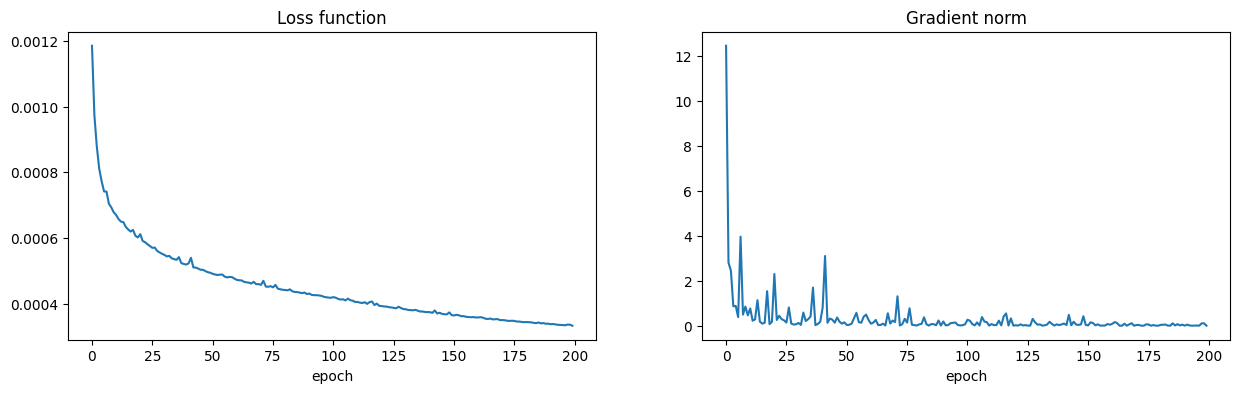

In [252]:
_, axs = plt.subplots(1, 2, figsize=(15, 4))

axs[0].plot(loss_val)
axs[0].set_title("Loss function")
axs[0].set_xlabel("epoch")

axs[1].plot(err_val)
axs[1].set_title("Gradient norm")
axs[1].set_xlabel("epoch")

plt.show()

In [253]:
accuracy = np.mean([predict(w[-1], X_test, model)==Y_test])
print("Accuracy of the logistic regression classifier: {:.2f}%".format(accuracy*100))

Accuracy of the logistic regression classifier: 98.88%


In [254]:
value_list = [
    {"digits":[0, 1], "N_train": 4000, "legend":"[0, 1] - 4000"},
    {"digits":[2, 3], "N_train": 4000, "legend":"[2, 3] - 4000"},
    {"digits":[4, 5], "N_train": 4000, "legend":"[4, 5] - 4000"},
    {"digits":[6, 7], "N_train": 4000, "legend":"[6, 7] - 4000"},
    {"digits":[8, 9], "N_train": 4000, "legend":"[8, 9] - 4000"},
]

100%|██████████| 30/30 [00:01<00:00, 26.07it/s]


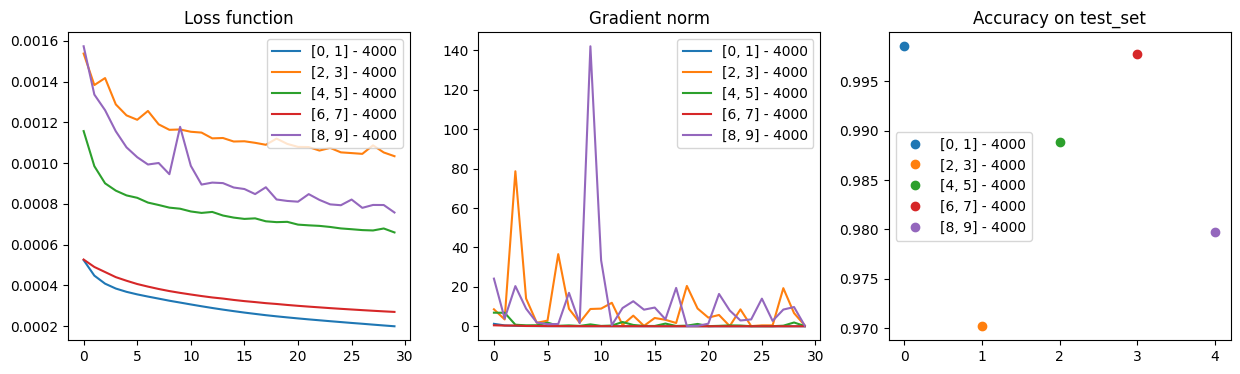

In [255]:
_, axs = plt.subplots(1, 3, figsize=(15, 4))

for i, value in enumerate(value_list):
    X_train, Y_train, X_test, Y_test = get_data_given_indeces_and_split(data, value["digits"], value["N_train"])
    w, loss_val, grads_val, err_val = SGD(loss_func, grad_func, model, np.ones(d)*1e-5, (X_train, Y_train), 512, 30)
    accuracy = np.mean([predict(w[-1], X_test, model)==Y_test])

    axs[0].plot(loss_val)
    axs[1].plot(err_val)
    axs[2].plot(i, accuracy, "o")

axs[0].set_title("Loss function")
axs[0].legend([v["legend"] for v in value_list])
axs[1].set_title("Gradient norm")
axs[1].legend([v["legend"] for v in value_list])
axs[2].set_title("Accuracy on test_set")
axs[2].legend([v["legend"] for v in value_list])

plt.show()

All accuracies are very high but some pairs of digits are more difficult to differenciate than others

In [258]:
value_list = [
    {"digits":[2, 3], "N_train": 500, "legend":"[2, 3] - 500"},
    {"digits":[2, 3], "N_train": 1000, "legend":"[2, 3] - 1000"},
    {"digits":[2, 3], "N_train": 2000, "legend":"[2, 3] - 2000"},
    {"digits":[2, 3], "N_train": 4000, "legend":"[2, 3] - 4000"},
    {"digits":[2, 3], "N_train": 6000, "legend":"[2, 3] - 6000"},
    {"digits":[2, 3], "N_train": 8000, "legend":"[2, 3] - 8000"},
]

100%|██████████| 30/30 [00:00<00:00, 31.90it/s]


N_train too big, was brouoght to 0.90*N


100%|██████████| 30/30 [00:01<00:00, 24.73it/s]


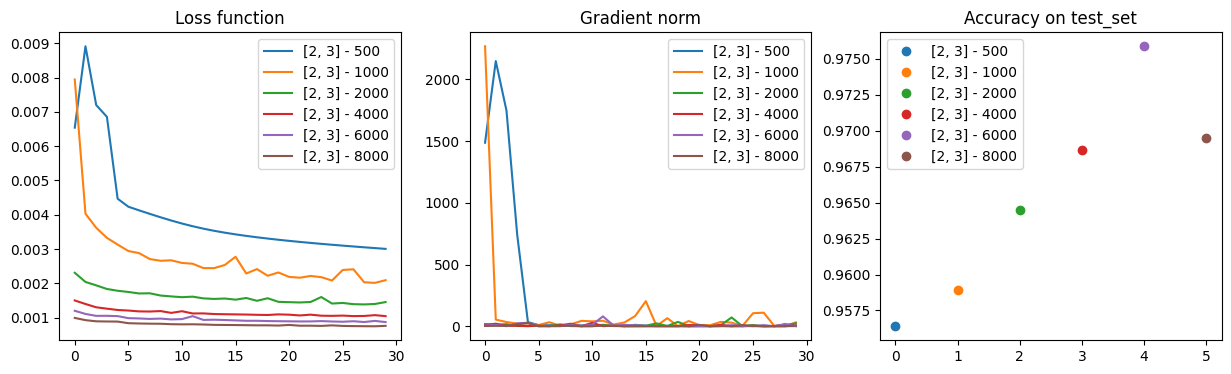

In [259]:
_, axs = plt.subplots(1, 3, figsize=(15, 4))

for i, value in enumerate(value_list):
    X_train, Y_train, X_test, Y_test = get_data_given_indeces_and_split(data, value["digits"], value["N_train"])
    w, loss_val, grads_val, err_val = SGD(loss_func, grad_func, model, np.ones(d)*1e-5, (X_train, Y_train), 512, 30)
    accuracy = np.mean([predict(w[-1], X_test, model)==Y_test])

    axs[0].plot(loss_val)
    axs[1].plot(err_val)
    axs[2].plot(i, accuracy, "o")

axs[0].set_title("Loss function")
axs[0].legend([v["legend"] for v in value_list])
axs[1].set_title("Gradient norm")
axs[1].legend([v["legend"] for v in value_list])
axs[2].set_title("Accuracy on test_set")
axs[2].legend([v["legend"] for v in value_list])

plt.show()

We can see here that with growing k the final loss is always lower, BUT the final accuracy is not, meaning that in the last case we most probably overfit the data